In [ ]:
# This version of Scikit-learn is needed for our PyCaret library
!pip install --user -U scikit-learn==0.23.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Install PyCaret.
# If working on Colab, PyCaret library needs to be installed everytime we are trying to access it.

!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The Attached image is to give our team members an idea what PyCaret is and how we plan on utilizing it.
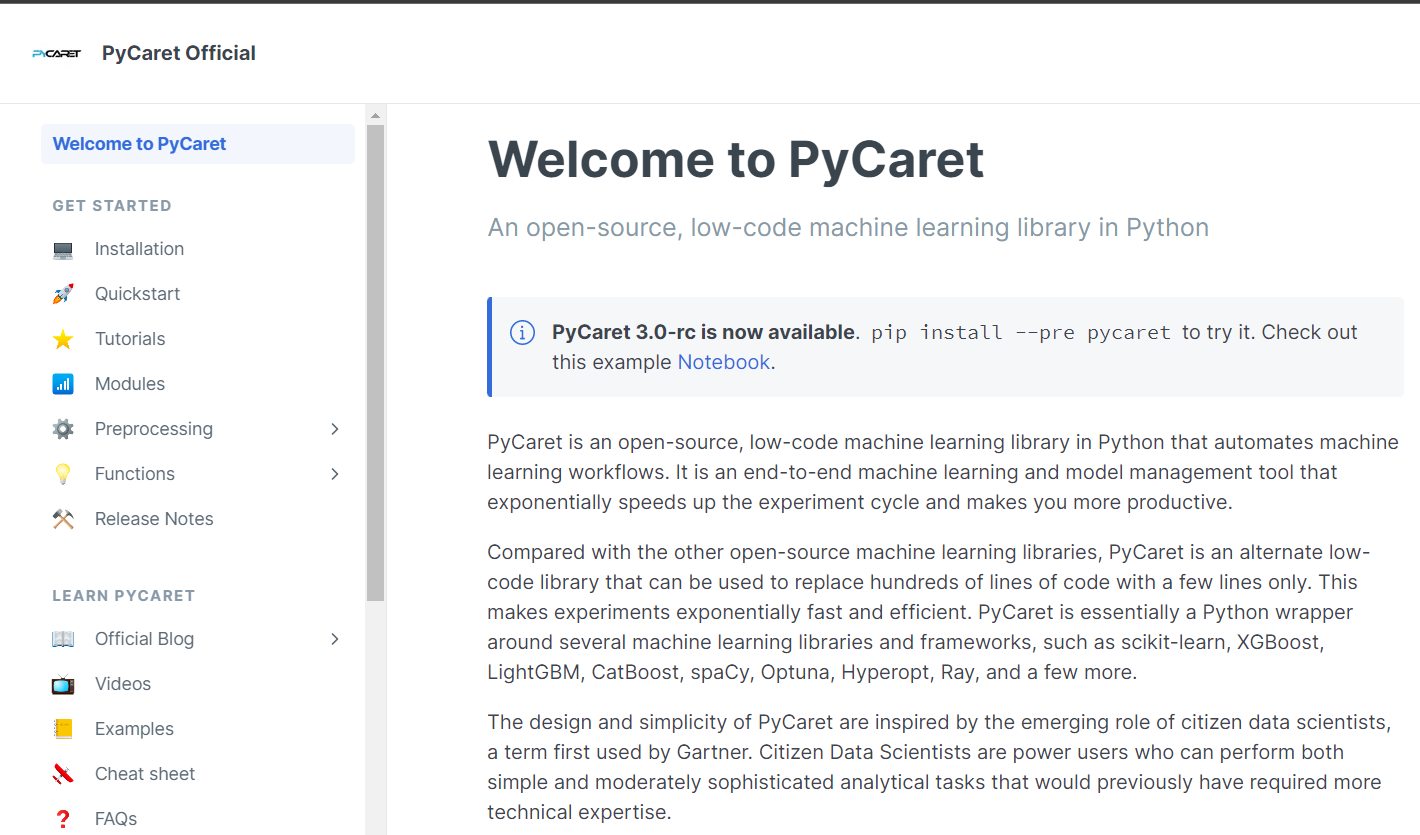

In [ ]:
# Check current version is up to date with PyCaret website

from pycaret.utils import version
version()

'2.3.10'

In [ ]:
# Import local files to Google Colab
from google.colab import files
uploaded = files.upload()

Saving config.py to config (1).py


In [ ]:
from config import db_password

In [ ]:
# Import dependencies
from pycaret.regression import *
import pandas as pd
import numpy as np 
import psycopg2
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import imblearn

In [ ]:
# Create connection to AWS database

connection = psycopg2.connect(
    host = 'launch-it-1.cyo6pvehqvyz.us-east-1.rds.amazonaws.com',
    port = 5432,
    user = 'postgres',
    password = db_password,
    database='launch-it-1'
    )
cursor=connection.cursor()

In [ ]:
# Using pandas to execute SQL queries
sql = """
SELECT * from launchit
"""
df = pd.read_sql(sql, con=connection)

In [ ]:
# Display dataframe content
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,TCKR,sector,industry,country,growth_rate,target_median_price,target_mean_price,target_high_price
0,2019-12-19,11.000,11.96,10.50,10.70,10.70,89400.0,INDO,Energy,Oil & Gas E&P,Indonesia,1.206,15.0,15.0,15.0
1,2019-12-20,10.808,12.49,9.25,9.65,9.65,503000.0,INDO,Energy,Oil & Gas E&P,Indonesia,1.206,15.0,15.0,15.0
2,2019-12-23,8.790,8.79,7.25,7.81,7.81,117400.0,INDO,Energy,Oil & Gas E&P,Indonesia,1.206,15.0,15.0,15.0
3,2019-12-24,7.500,7.64,6.00,6.41,6.41,102800.0,INDO,Energy,Oil & Gas E&P,Indonesia,1.206,15.0,15.0,15.0
4,2019-12-26,6.420,7.72,6.42,7.41,7.41,78400.0,INDO,Energy,Oil & Gas E&P,Indonesia,1.206,15.0,15.0,15.0


In [ ]:
# Check Data Types for all columns
df.dtypes


Date                   datetime64[ns]
Open                          float64
High                          float64
Low                           float64
Close                         float64
Adj Close                     float64
Volume                        float64
TCKR                           object
sector                         object
industry                       object
country                        object
growth_rate                   float64
target_median_price           float64
target_mean_price             float64
target_high_price             float64
dtype: object

In [ ]:
# Up for discussion, keep or remove.
# Convert sector,industry and country columns categories from a string to integer.
# .cat.codes converts a category from a string representation into an integer representation.
df['sector']=df['sector'].astype('category').cat.codes
df['country']=df['country'].astype('category').cat.codes
df['industry']=df['industry'].astype('category').cat.codes
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,TCKR,sector,industry,country,growth_rate,target_median_price,target_mean_price,target_high_price
0,2019-12-19,11.000,11.96,10.50,10.70,10.70,89400.0,INDO,4,59,10,1.206,15.0,15.0,15.0
1,2019-12-20,10.808,12.49,9.25,9.65,9.65,503000.0,INDO,4,59,10,1.206,15.0,15.0,15.0


In [ ]:
# Calculate the correlation
df.corr()

,Open,High,Low,Close,Adj Close,Volume,sector,industry,country,growth_rate,target_median_price,target_mean_price,target_high_price
Open,1.000000,0.998789,0.999135,0.998624,0.998433,0.053386,0.125407,0.150008,0.067462,-0.001751,0.087424,0.087424,0.120925
High,0.998789,1.000000,0.997961,0.998417,0.998249,0.055956,0.125370,0.149401,0.066749,-0.001164,0.086713,0.086713,0.120099
Low,0.999135,0.997961,1.000000,0.999390,0.999172,0.051625,0.125497,0.150497,0.068316,-0.002408,0.088142,0.088142,0.121731
Close,0.998624,0.998417,0.999390,1.000000,0.999804,0.054106,0.125793,0.150329,0.068013,-0.001744,0.087842,0.087842,0.121441
Adj Close,0.998433,0.998249,0.999172,0.999804,1.000000,0.054456,0.126045,0.151364,0.067974,-0.001327,0.087970,0.087970,0.121620
Volume,0.053386,0.055956,0.051625,0.054106,0.054456,1.000000,-0.003832,0.060576,-0.023517,-0.010584,-0.010427,-0.010427,-0.000344
sector,0.125407,0.125370,0.125497,0.125793,0.126045,-0.003832,1.000000,0.368318,0.085423,-0.102798,-0.000493,-0.000493,0.014026
industry,0.150008,0.149401,0.150497,0.150329,0.151364,0.060576,0.368318,1.000000,0.059102,-0.098072,-0.024668,-0.024668,-0.019625
country,0.067462,0.066749,0.068316,0.068013,0.067974,-0.023517,0.085423,0.059102,1.000000,0.045805,-0.012941,-0.012941,-0.000325
growth_rate,-0.001751,-0.001164,-0.002408,-0.001744,-0.001327,-0.010584,-0.102798,-0.098072,0.045805,1.000000,-0.002360,-0.002360,0.000186


In [ ]:
# Create Correlation matrix based on target variable: In this case "growth_rate" or "Volume"
corr_matrix = df.corr().round(3)
print(corr_matrix["Volume"].sort_values(ascending=False))

Volume                 1.000
industry               0.061
High                   0.056
Close                  0.054
Adj Close              0.054
Open                   0.053
Low                    0.052
target_high_price     -0.000
sector                -0.004
target_median_price   -0.010
target_mean_price     -0.010
growth_rate           -0.011
country               -0.024
Name: Volume, dtype: float64


Based on the above Corr. Matrix, we notice a very low correlation between our current features and expected target,either positively or negatively. This is still being worked on. We might add more features to the DF or decide on a different target.

In [ ]:
# PyCaret Setup command:
reg = setup(data = df, target = 'Volume', session_id = 789, train_size = 0.80,
            # ignore_features=["TCKR","Adj Close"],
            feature_selection = True,
            transformation= True,
            remove_outliers=True,
            high_cardinality_features= ['country','sector']
            )

,Description,Value
0,session_id,789
1,Target,Volume
2,Original Data,"(294310, 15)"
3,Missing Values,False
4,Numeric Features,12
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,True
8,High Cardinality Method,frequency
9,Transformed Train Set,"(223675, 513)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[], target='Volume',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy=...
                ('dummy', Dummify(target='Volume')),
                ('fix_perfect', Remove_100(target='Volume')),
                ('clean_names', Clean_Colum_Names()),
                ('feature_select',
        

In [ ]:
# Display all models available in PyCaret Library and abbreviation
models()

INFO:logs:gpu_param set to False


,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [ ]:
# Compare models & Select top 3 performers
# best_model = compare_models()
best_model = compare_models(fold=10,n_select=3)
                            

INFO:logs:Initializing compare_models()
INFO:logs:compare_models(include=None, fold=10, round=4, cross_validation=True, sort=R2, n_select=3, budget_time=None, turbo=True, errors=ignore, fit_kwargs=None, groups=None, experiment_custom_tags=None, probability_threshold=None, verbose=True, display=None, exclude=None)
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Preparing display monitor


IntProgress(value=0, description='Processing: ', max=94)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:28:30
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Elastic Net


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,1.102986e+06,2.470500e+13,4873414.325,0.3795,2.7466,38.2318,6.448


INFO:logs:Initializing Linear Regression
INFO:logs:Total runtime is 7.727146148681641e-05 minutes
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=lr, fold=KFold(n_splits=10, random_state=None, shuffle=False), round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, verbose=False, system=False, metrics=None, experiment_custom_tags=None, add_to_model_list=True, probability_threshold=None, display=<pycaret.internal.Display.Display object at 0x7f3cacf3dfd0>, return_train_score=False, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Linear Regression Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with KFold(n_splits=10, random_state=None, shuffle=False), n_jobs=-1

In [ ]:
# Still in progress.
# The below is incomplete code, it will only depend on our selected features & target.
# Then our goal is to select to the top three models and continue into prediction. 